In [1]:
import numpy as np
import pandas as pd
import os
# import sys

In [2]:
from psychrochart import PsychroChart , load_config
import psychrolib as psylib
psylib.SetUnitSystem(psylib.SI)

from CoolProp.HumidAirProp import HAPropsSI

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### several function to calculate thermodynamic state

In [4]:
psylib.GetRelHumFromHumRatio(TDryBulb=298.75-273.15, HumRatio=0.0162, Pressure=101325)

0.7831800337162653

In [7]:
HAPropsSI('R','T',298.75,'P',101325,'W',0.0162)

0.7796973122676524

In [8]:
convert_to_hr = lambda T, W: HAPropsSI('R','T',T,'P',101325,'W',W)

# Chart Psychrometrics

### TODO:
- [x] Color RGBa
- [x] 

### pass in inputdata from dataframe    

In [17]:
def plot_psy_from_df(df_data, chart_template = 'ashrae', alpha = 0.6, save_fig_name = False):
    
    # df_data is a pandas dataframe, for example, read directly from table of expertiment data.
    
    # pre-configuration
    # Get a pre-configured style dict
    config_ashrae = load_config(chart_template)

    # customize configuration:
    # config_ashrae['figure']['x_label'] = None
    # config_ashrae['figure']['y_label'] = None
    config_ashrae['saturation']['linewidth'] = 5
    config_ashrae['chart_params']['with_constant_dry_temp'] = True
    config_ashrae['chart_params']['with_constant_humidity'] = True
    config_ashrae['chart_params']['with_constant_wet_temp'] = False
    config_ashrae['chart_params']['with_constant_h'] = False

    chart_customized_ashrae = PsychroChart(config_ashrae)
    # Plot the chart
    ax = chart_customized_ashrae.plot()
    points = {}
    connectors = []
    run=0#ROTEMS CODE - first run need to be out of the loop#######################################
    array_colors=[]#ROTEMS CODE - the 2D array that contains the different colors values####################################
    for i in df_data.index:
        
        # inlet
        air_in = 'air_in_{}'.format(i)
        T_air_in = df_data.loc[i, "T_a_in"]
        rh_air_in = df_data.loc[i, "hr_air_in"]        
        
        # outlet
        air_out = 'air_out_{}'.format(i)
        T_air_out = df_data.loc[i, "T_a_o_exp"]
        rh_air_out = df_data.loc[i, "hr_air_out"]
        
        # color
        #Rotem's Code strats:##################################################################################
        if (run==0):#the color of the first sample does not need to be sorted
            col=np.random.rand(3)
            color = np.append(col, alpha)
            array_colors.append(col)#stacking the different colors in a 2D list
        else:#for all the samples after the first sample:
            x=0
            similar=0
            while(x==0):#this loop will keep running until it will find a color that is different enough from all the other colors before 
                col=np.random.rand(3)
                color = np.append(col, alpha)
                for k in range(len(array_colors)):#this loop runs on all the colors that were used so far 
                    similar=0
                    for j in range(3):#this loop runs on the three different color values
#**************************IF YOU RUN A PROGRAMM WITH MORE THAN 24 VALUES YOU WILL NEED TO MAKE THE VALUES IN******************** 
#**************************(0.25+/-array_colors[k][j]))SMALLER THAN 0.25, OTHERWISE IT WILL NOT STOP RUNNING*********************
                        if (color[j]<(0.25+array_colors[k][j])) and (color[j]>(array_colors[k][j]-0.25)):
                            similar+=1#a test value for color who is too similar to a previews colors 
                    if similar==3: break
                        
                if (similar>=3):#if the tested color has three color values whom are close to some of the colors before, so the
                    #loop will keep running another time with a new color
                    x=0
                    similar=0
                else:#if the similar value is not 3 ,so the tested color is different enough from all the colors before
                    x=1
                    array_colors.append(col)
                    print(color)
        run=1#so the first run will be confirmed out of the loop
        #Rotem's Code ends:##################################################################################
        
        # plot points
        point = {air_in: {'label': 'air_in_{}'.format(i),
                           'style': {'color': color,
                                     'marker': 'X', 'markersize': 15},
                           'xy': (T_air_in-273.15, rh_air_in*100)},
              air_out: {
                  'label': 'air_out_{}'.format(i),
                  'style': {'color': color,
                            'marker': 'o', 'markersize': 10},
                  'xy': (T_air_out-273.15, rh_air_out*100)}                      
                    }
        # plot connectors
        # here the color CANNOT be specified by string e.g. red...
        
        connector = {'start': air_in,
                       'end': air_out,
                       'style': {'color': color,
                                 "linewidth": 2, "linestyle": "-."}}
        # add into dict and list
        points.update(point)
        connectors.append(connector)
        
    # add points and conncection to chart
    chart_customized_ashrae.plot_points_dbt_rh(points, connectors)

    # Add a legend
    chart_customized_ashrae.plot_legend(markerscale=.7, frameon=False, fontsize=8, labelspacing=1.2, ncol = 3)
    
    if save_fig_name:
        ax.get_figure().savefig(save_fig_name)
    
    return ax.get_figure()

# update Aug 2020
- draw psychro of dempav

In [6]:
df_exp_dempav = pd.read_excel('../exp_data/dempav_T_des_corrected.xlsx', index_col=0)
df_exp_dempav

,T_a_in,hr_air_in,m_a_in,T_d_in,xi_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,x_a_in,x_a_o_exp
0,298.02,0.480462,0.018848,287.44,0.318302,0.102670,290.21,0.476947,286.230,0.009457,0.005773
1,300.51,0.553303,0.036283,292.20,0.318186,0.102670,294.81,0.538242,290.092,0.012683,0.008716
2,298.02,0.458659,0.032644,284.16,0.318572,0.102670,287.98,0.506137,281.766,0.009022,0.005308
3,301.31,0.504712,0.036150,290.94,0.318174,0.102669,293.69,0.519635,288.468,0.012112,0.007844
4,299.87,0.423994,0.045742,290.34,0.318171,0.102668,292.89,0.525218,288.366,0.009311,0.007542
5,301.71,0.429149,0.050290,292.12,0.318252,0.102675,297.38,0.404108,289.957,0.010514,0.007633
6,302.39,0.488868,0.050221,293.32,0.318283,0.102676,300.51,0.419009,291.612,0.012498,0.009558
7,301.99,0.447363,0.018140,294.30,0.343938,0.104834,296.50,0.332930,293.038,0.011151,0.005948
8,308.02,0.285443,0.033955,298.14,0.344078,0.104832,299.94,0.375312,296.535,0.009994,0.008262
9,295.22,0.649549,0.037419,297.52,0.318444,0.102671,296.66,0.492922,297.085,0.010821,0.008935


In [9]:
df_exp_dempav.drop(df_exp_dempav.index[[0]], inplace=True)
df_exp_dempav

,T_a_in,hr_air_in,m_a_in,T_d_in,xi_d_in,m_d_in,T_a_o_exp,hr_air_out,T_d_o_exp,x_a_in,x_a_o_exp
2,298.02,0.458659,0.032644,284.16,0.318572,0.102670,287.98,0.506137,281.766,0.009022,0.005308
3,301.31,0.504712,0.036150,290.94,0.318174,0.102669,293.69,0.519635,288.468,0.012112,0.007844
4,299.87,0.423994,0.045742,290.34,0.318171,0.102668,292.89,0.525218,288.366,0.009311,0.007542
5,301.71,0.429149,0.050290,292.12,0.318252,0.102675,297.38,0.404108,289.957,0.010514,0.007633
6,302.39,0.488868,0.050221,293.32,0.318283,0.102676,300.51,0.419009,291.612,0.012498,0.009558
7,301.99,0.447363,0.018140,294.30,0.343938,0.104834,296.50,0.332930,293.038,0.011151,0.005948
8,308.02,0.285443,0.033955,298.14,0.344078,0.104832,299.94,0.375312,296.535,0.009994,0.008262
9,295.22,0.649549,0.037419,297.52,0.318444,0.102671,296.66,0.492922,297.085,0.010821,0.008935
10,290.56,0.736427,0.046145,288.03,0.276610,0.104692,289.51,0.598032,286.984,0.009162,0.006936
11,287.82,0.740536,0.046695,288.08,0.276609,0.104692,288.95,0.596045,287.850,0.007716,0.006667


[0.24381971 0.18891633 0.97633632 0.8       ]
[0.93303317 0.84006151 0.37582053 0.8       ]
[0.02185328 0.53985102 0.28385013 0.8       ]
[0.68589521 0.21137486 0.34021025 0.8       ]
[0.6210482  0.83262917 0.79751055 0.8       ]
[0.73793881 0.73954773 0.01862868 0.8       ]
[0.14476357 0.92339067 0.37793813 0.8       ]
[0.2296145  0.22145175 0.26928894 0.8       ]
[0.00895747 0.76867214 0.74578872 0.8       ]
[0.76969868 0.28886983 0.01931973 0.8       ]
[0.34926653 0.94640547 0.65085455 0.8       ]
[0.97847072 0.3179076  0.42003417 0.8       ]
[0.1792763  0.89826765 0.01043204 0.8       ]
[0.55550329 0.28315983 0.75205203 0.8       ]
[7.71105097e-01 2.25116109e-04 9.74621489e-01 8.00000000e-01]
[0.63342046 0.94256855 0.52376421 0.8       ]
[0.93805576 0.04938134 0.54084064 0.8       ]
[0.67608854 0.69005162 0.45543924 0.8       ]
[0.28738746 0.5920908  0.14522715 0.8       ]
[0.28983964 0.47290324 0.91744971 0.8       ]
[0.28161517 0.00408709 0.00960815 0.8       ]
[0.46830194 0.8890

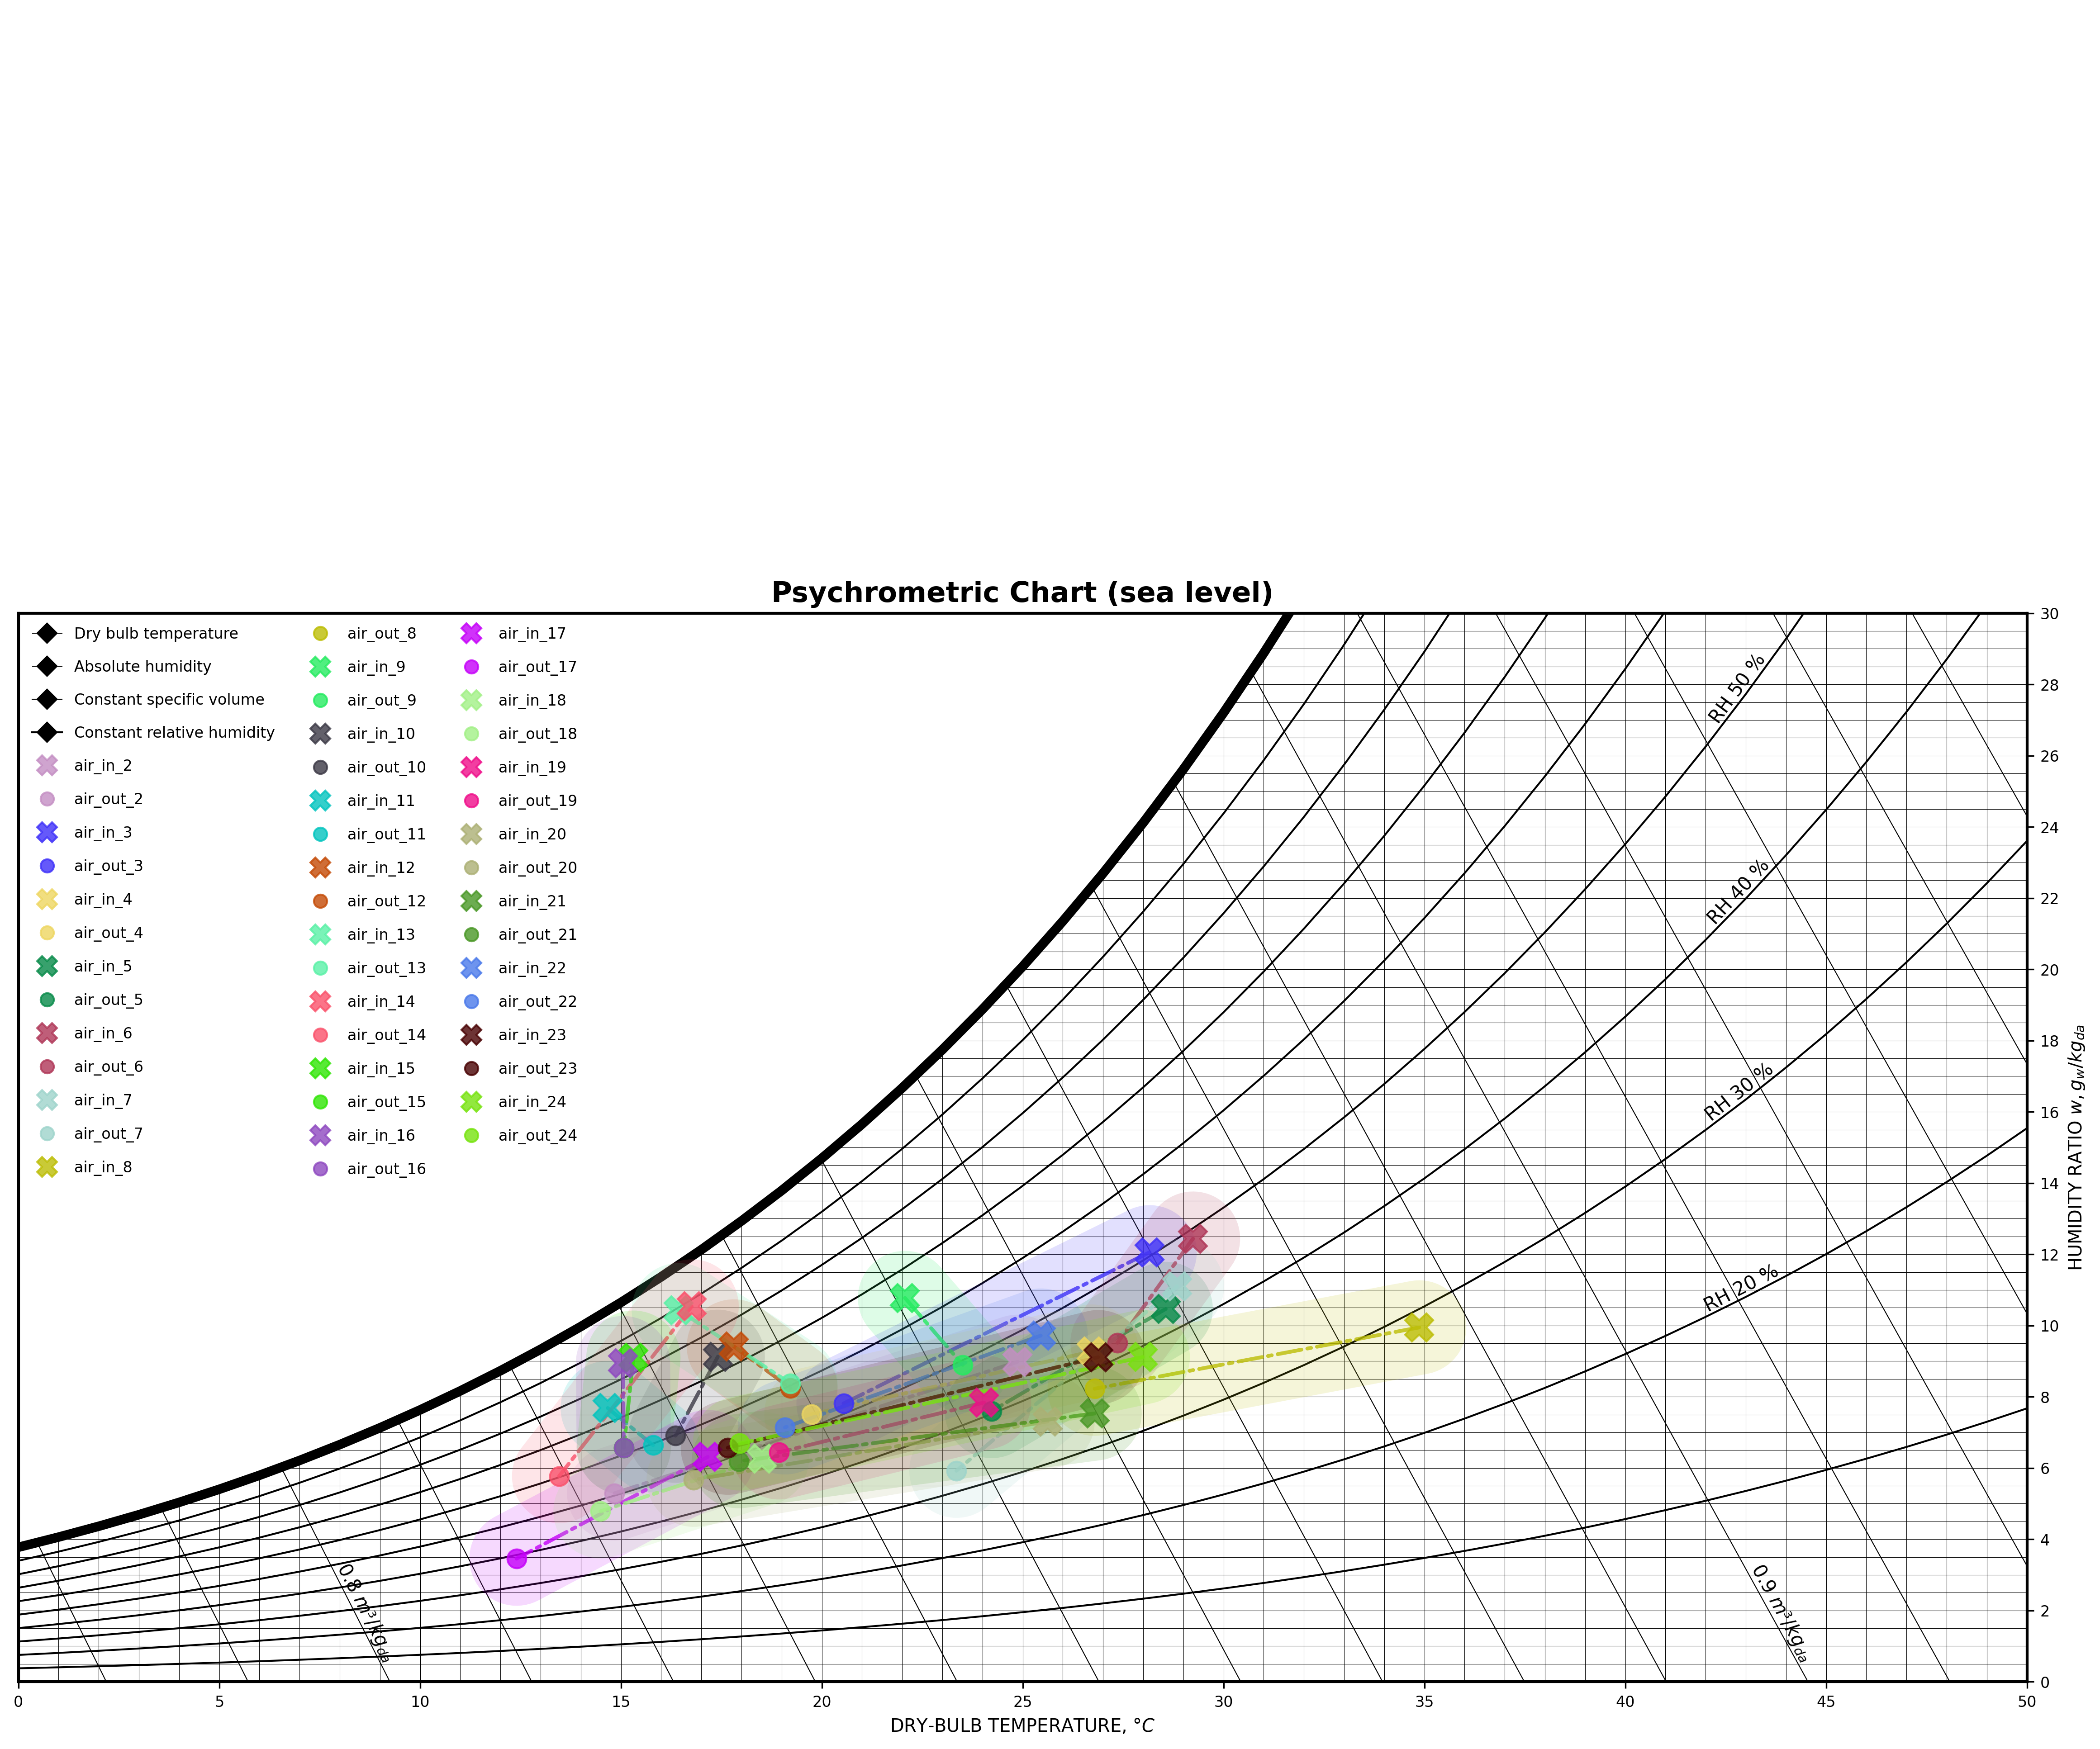

In [18]:
plot_psy_from_df(df_data=df_exp_dempav.iloc[0:23,:],alpha=0.8)

[0.82835271 0.69671469 0.25815963 0.8       ]


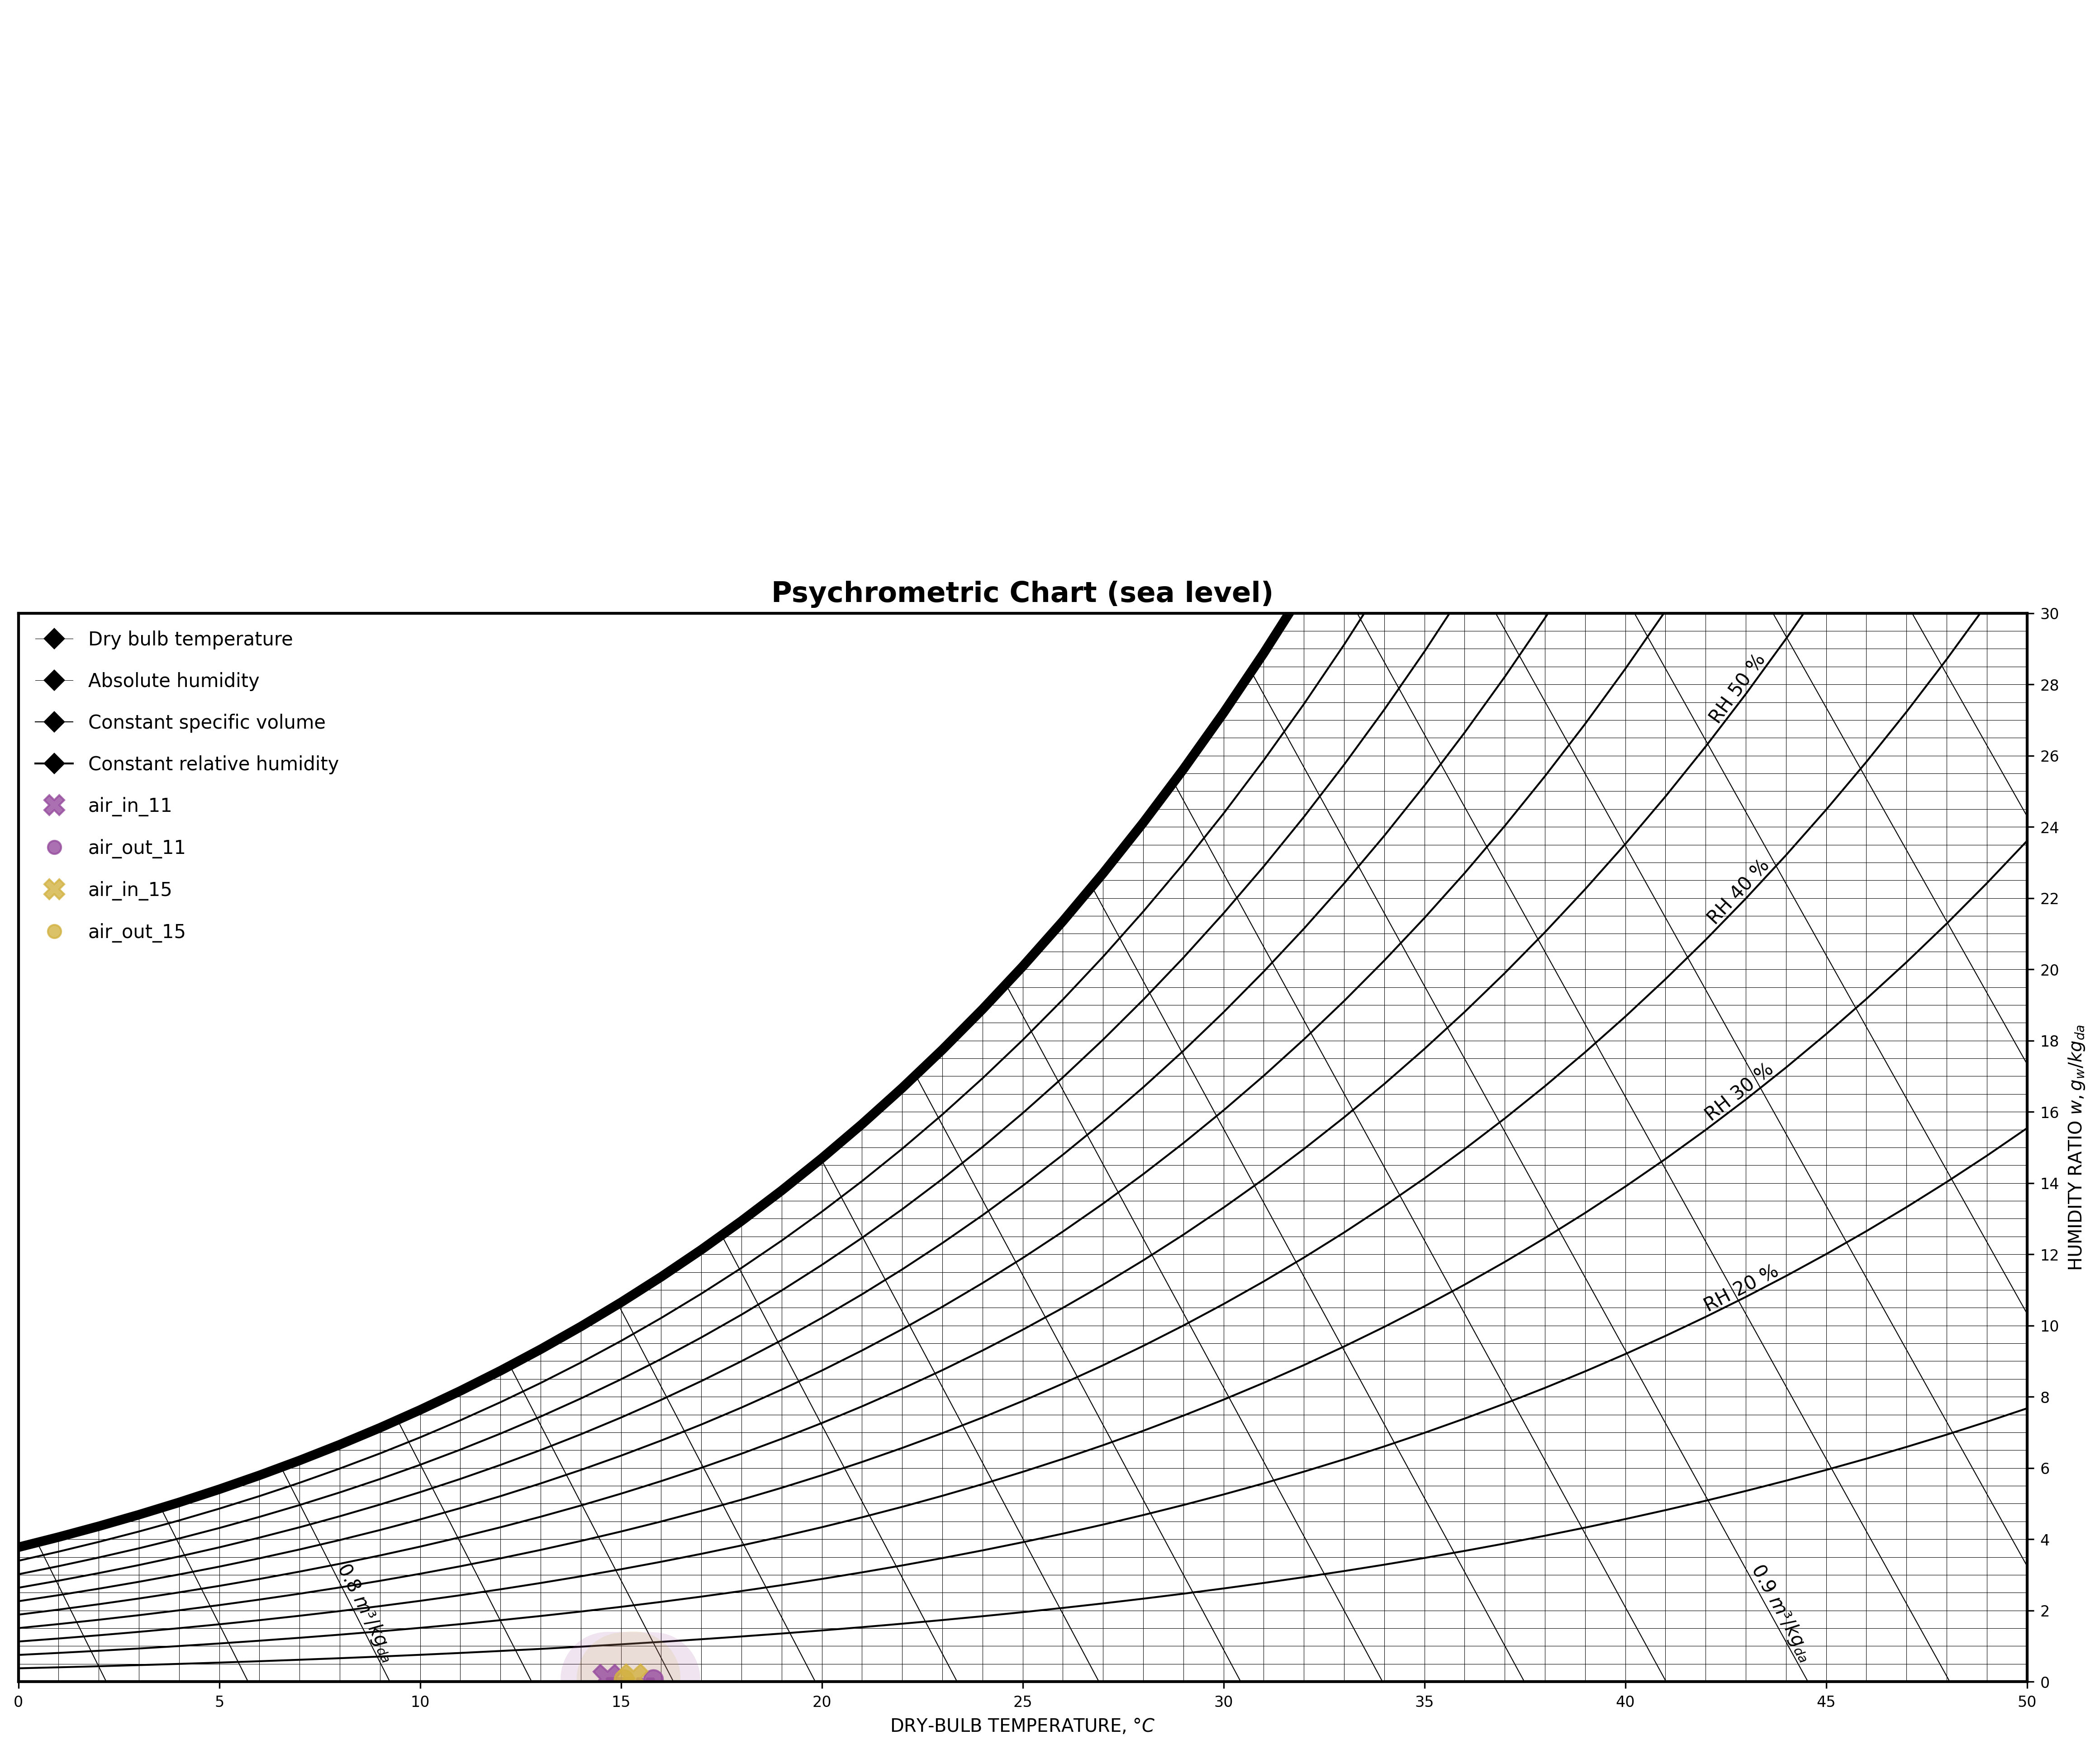

In [12]:
plot_psy_from_df(df_data=df_exp_dempav.iloc[[9,13],:], alpha=0.8)

In [ ]:
plot_psy_from_df(df_data=df_exp_dempav.iloc[14:20,:], alpha=0.8)